<img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;"> [Run In Google Colab](https://colab.research.google.com/github/themis-ai/capsa/blob/main/notebooks/1_Faces.ipynb)


## Tutorial: How to use capsa to detect bias and uncertainty 

## Background

Modern AI models demonstrate remarkable potential across various applications. So far, our primary focus has been on their accuracy, which is an essential metric for evaluating an AI model's performance and determining whether it has been adequately trained. However, despite their high accuracy, we are not seeing these AI models deployed in our everyday lives. The absence of fully autonomous cars or AI-driven solutions to pressing issues raises questions about their practical implementation.

This disparity stems from the fundamental difference between how we define accuracy and what we expect from a trustworthy system. When it comes to deploying AI models in safety-critical systems, accuracy is a prerequisite. However, we also need these models to discern when they can be trusted to make decisions and when they cannot. The current state-of-the-art models lack a trust metric accompanying their predictions, rendering them unsuitable for deployment in safety-critical applications. To bridge this gap, it is crucial to develop AI models with built-in trust mechanisms that can reliably support decision-making in real-world scenarios.


## Defining trust (risk)

When it comes to trusting an AI model, it's essential to define the trust metric it needs to output along with its predictions. Typically, we refer to these metrics as "risk metrics." However, we can categorize risk into three distinct categories that impact the trustworthiness of the model.

The first category is **Representation Bias**, which refers to the potential for the model to favor certain groups or types of data over others, leading to inaccuracies in its predictions with under-represented data.

The second category is **Epistemic Uncertainty**, also known as Model Uncertainty, which describes the uncertainty associated with the model's ability to make accurate predictions based on the data it has been trained on. Model uncertainty can be improved by training the model longer, or picking a model architecture with higher predictive capacity.

The third category is **Aleatoric Uncertainty**, also known as Data Uncertainty, which refers to the inherent noise or unpredictability in the data itself. This type of uncertainty can arise due to factors such as measurement errors or natural variations in the data. This can only be improved by improving the data source, or manually fixing the inherent issues that lie withing the dataset.

By addressing these three categories of risk, we can build more trustworthy and reliable AI models that are better equipped to handle complex real-world scenarios.

## How capsa works

In this tutorial, we will explore how we can utilize capsa's wrappers to make our models risk-aware. Capsa is a python library that offers various wrappers that augment a given model with specific risk metrics. By wrapping a model with one or more capsa wrappers, we can add the model risk awareness capabilities. This new wrapped model outputs risk metrics alongside of it's predictions.

Overall, capsa offers a powerful set of tools that can help us build more reliable and trustworthy AI models. With capsa's wrappers, we can effectively mitigate various forms of risks we have mentioned previously, such as representation bias, epistemic uncertainty, and aleatoric uncertainty, which are critical factors in building trustworthy models.

![Capsa overview](https://raw.githubusercontent.com/aamini/introtodeeplearning/2023/lab3/img/capsa_overview.png)

## Import

Let's get started by installing the necessary dependencies:

In [ ]:
# Import Tensorflow 2.0
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package for visualization
!pip install git+https://github.com/aamini/introtodeeplearning.git@2023
import mitdeeplearning as mdl

# Download and import capsa
!pip install capsa
import capsa

## Dataset

For the purpose of this tutorial, we are focusing on the facial detection problem. We have a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces).

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale dataset (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). A large-scale dataset with many images across many different categories. We will take negative examples from a variety of non-human categories.

We will evaluate trained models on an independent test dataset of face images to diagnose and mitigate potential issues with *bias, fairness, and confidence*. This will be a larger test dataset for evaluation purposes.

We begin by importing these datasets. For the purpose of this tutorial, we have a `DatasetLoader` class that does a bit of data pre-processing to import the training data in a usable format.

In [ ]:
batch_size = 64

# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face_2023_perturbed_small.h5', 'https://www.dropbox.com/s/tbra3danrk5x8h5/train_face_2023_perturbed_small.h5?dl=1')
# Instantiate a DatasetLoader using the downloaded dataset
train_loader = mdl.lab3.DatasetLoader(path_to_training_data, training=True, batch_size=batch_size)
test_loader = mdl.lab3.DatasetLoader(path_to_training_data, training=False, batch_size=batch_size)

## Building robustness to bias and uncertainty

Remember that we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an independent test dataset. We want to mitigate the effects of unwanted bias and uncertainty on the model's predictions and performance. Our goal is to build the best-performing, most robust model, one that achieves high classification accuracy across the entire test dataset.

To achieve this, we are back to considering the three metrics introduced with capsa: (1) representation bias, (2) data or aleatoric uncertainty, and (3) model or epistemic uncertainty. Note that all three of these metrics are different! For example, we can have well-represented examples that still have high epistemic uncertainty.

## Detecting bias with Capsa

Capsa can be used to learn the latent structure of a database and uncover feature representation disparities, inspired by the approach of [uncover hidden biases](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf). As long as we have a predefined model, capsa can do this in one line!

This sets the foundation for quantifying a key risk metric -- representation bias -- for the facial detection problem. In working to improve your model's performance, you will want to consider representation bias carefully and think about how you could mitigate the effect of representation bias.

We will begin by defining a standard CNN-based classifier. We will then use Capsa to wrap the model and build the risk-aware variant.

In [3]:
### Define the CNN classifier model ###

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1, n_filters=12):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([ 
    tf.keras.Input(shape=(64,64, 3)),
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=8*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model



## Capsa's `HistogramVAEWrapper`

With our base classifier, Capsa allows us to automatically define a VAE implementing that base classifier. Capsa's [`HistogramVAEWrapper`](https://themisai.io/capsa/api_documentation/HistogramVAEWrapper.html) builds this VAE to analyze the latent space distribution. 

Specifically, `capsa.HistogramVAEWrapper` constructs a histogram with `num_bins` bins across every dimension of the latent space, and then calculates the joint probability of every sample according to the constructed histograms. The samples with the lowest joint probability have the lowest representation; the samples with the highest joint probability have the highest representation.

`capsa.HistogramVAEWrapper` takes in a number of arguments including:
1. `base_model`: the model to be transformed into the risk-aware variant.
2. `num_bins`: the number of bins we want to discretize our distribution into. 
2. `queue_size`: the number of samples we want to track at any given point.
3. `decoder`: the decoder architecture for the VAE.

HistogramVAEWrapper also has model reversing functionality. Therefore, we don't have to pass it a decoder. It can simply reverse the base_model to generate a decoder. But for the sake of this tutorial, let's predefine a decoder as well.


In [4]:
### Define the decoder architecture for the facial detection VAE ###

def make_face_decoder_network(n_filters=12):
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, 
                                      padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=2*2*8*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(2, 2, 8*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=6*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

We are ready to create the wrapped model using `capsa.HistogramVAEWrapper` by passing in the relevant arguments!

We can take our standard CNN classifier, wrap it with `capsa.HistogramVAEWrapper`, and build the wrapped model. The wrapper then enablings semi-supervised training for the facial detection task. As the wrapped model trains, the classifier weights are updated, and the VAE-wrapped model learns to track feature distributions over the latent space. More details of the `HistogramVAEWrapper` and how it can be used are [available here](https://themisai.io/capsa/api_documentation/HistogramVAEWrapper.html).

We can then evaluate the representation bias of the classifier on the test dataset. By calling the `wrapped_model` on our test data, we can automatically generate representation bias and uncertainty scores that are normally manually calculated. Let's wrap our base CNN classifier using Capsa, train and build the resulting model, and start to process the test data: 

In [ ]:
### Estimating representation bias with Capsa HistogramVAEWrapper ###

model = make_standard_classifier()
# Wrap the CNN classifier for latent encoding with a VAE wrapper
wrapped_model = capsa.HistogramVAEWrapper(model, num_bins=5, queue_size=20000, 
    latent_dim = 32, decoder=make_face_decoder_network())

# Build the model for classification, defining the loss function, optimizer, and metrics
wrapped_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # for classification
    metrics=[tf.keras.metrics.BinaryAccuracy()], # for classification
)

# Train the wrapped model for 6 epochs by fitting to the training data
history = wrapped_model.fit(
        train_loader,
        epochs=6,
        batch_size=batch_size,
  )

## Evaluation

# Get all faces from the testing dataset
test_imgs = test_loader.get_all_faces()

# Call the Capsa-wrapped classifier to generate outputs: predictions, uncertainty, and bias!
out = wrapped_model.predict(test_imgs, batch_size=512)

## Analyzing Representation Bias with Capsa

From the above output, we have an estimate for the representation bias score! We can analyze the representation scores to start to think about manifestations of bias in the facial detection dataset.

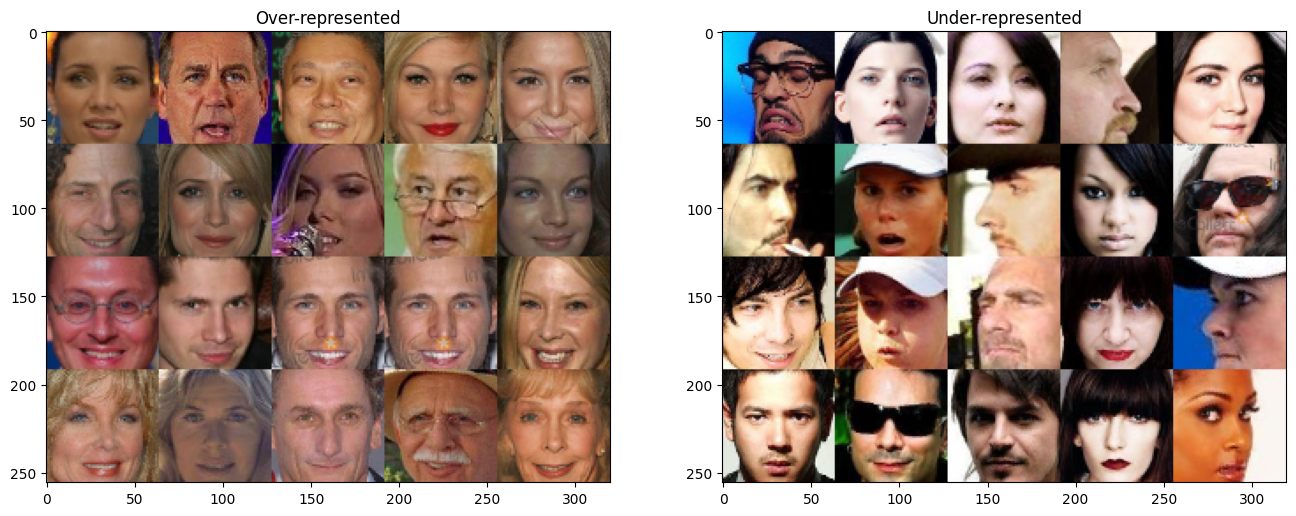

In [9]:
### Analyzing representation bias scores ###

# Sort according to lowest to highest representation scores
indices = np.argsort(out.bias, axis=None) # sort the score values themselves
sorted_images = test_imgs[indices] # sort images from lowest to highest representations
sorted_biases = out.bias.numpy()[indices] # order the representation bias scores
sorted_preds = out.y_hat.numpy()[indices] # order the prediction values


# Visualize the 20 images with the lowest and highest representation in the test dataset
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(sorted_images[-20:], (4, 5)))
ax[0].set_title("Over-represented")

ax[1].imshow(mdl.util.create_grid_of_images(sorted_images[:20], (4, 5)))
ax[1].set_title("Under-represented");

We can also quantify how the representation density relates to the classification accuracy by plotting the two against each other:

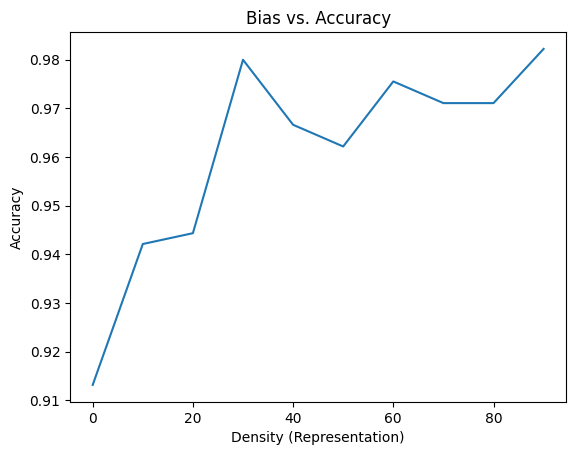

<Figure size 640x480 with 0 Axes>

In [10]:
# Plot the representation density vs. the accuracy
plt.xlabel("Density (Representation)")
plt.ylabel("Accuracy")
averaged_imgs = mdl.lab3.plot_accuracy_vs_risk(sorted_images, sorted_biases, sorted_preds, "Bias vs. Accuracy")

These representations scores relate back to data examples, so we can visualize what the average face looks like for a given *percentile* of representation density:

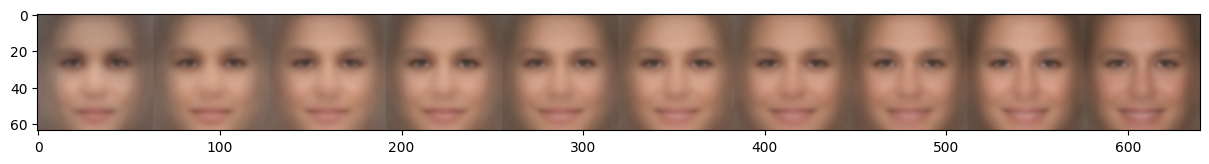

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
ax.imshow(mdl.util.create_grid_of_images(averaged_imgs, (1,10)))

## Analyzing Epistemic Uncertainty with Capsa

*Epistemic* uncertainty, or a model's uncertainty in its prediction, can arise from out-of-distribution data, missing data, or samples that are harder for the model to learn. This does not necessarily correlate with representation bias! Imagine the scenario of training an object detector for self-driving cars: even if the model is presented with many cluttered scenes, these samples still may be harder to learn than scenes with very few objects in them.

We will now use our VAE-wrapped facial detection classifier to analyze and estimate the epistemic uncertainty of the model trained on the facial detection task.

While most methods of estimating epistemic uncertainty are *sampling-based*, we can also use ***reconstruction-based*** methods -- like using VAEs -- to estimate epistemic uncertainty. If a model is unable to provide a good reconstruction for a given data point, it has not learned that area of the underlying data distribution well, and therefore has high epistemic uncertainty.



Since we've already used the `HistogramVAEWrapper` to calculate the histograms for representation bias quantification, we can use the exact same VAE wrapper to shed insight into epistemic uncertainty! Capsa helps us do exactly that. When we called the model, we returned the classification prediction, uncertainty, and bias for every sample:
`out = wrapped_model.predict(test_imgs, batch_size=512)`.

Let's analyze these estimated uncertainties:

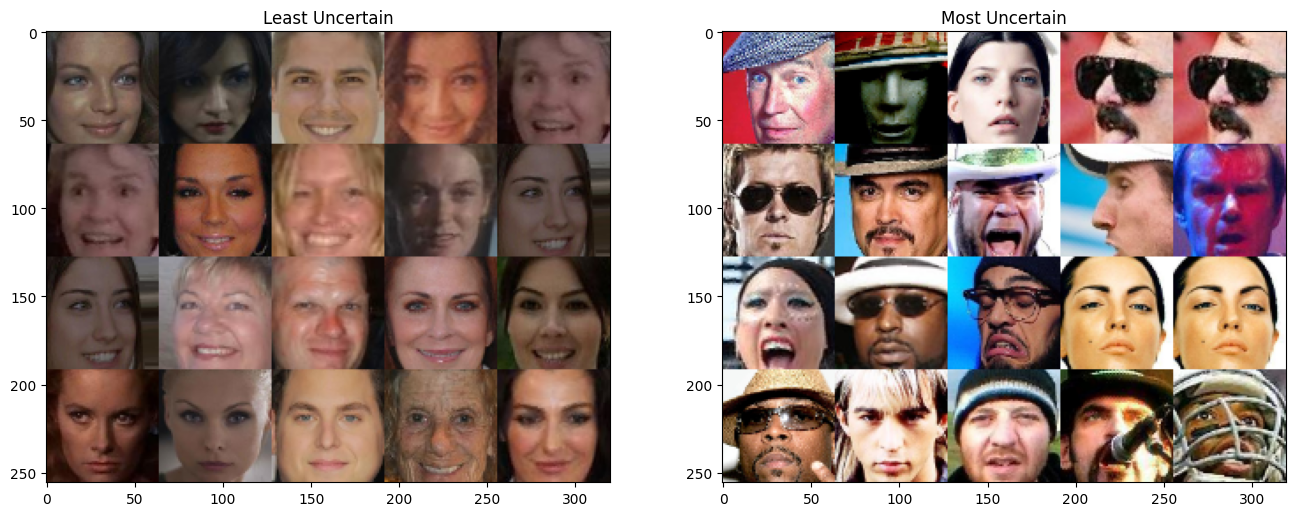

In [12]:
### Analyzing epistemic uncertainty estimates ###

# Sort according to epistemic uncertainty estimates
epistemic_indices = np.argsort(out.epistemic, axis=None) # sort the uncertainty values
epistemic_images = test_imgs[epistemic_indices] # sort images from lowest to highest uncertainty
sorted_epistemic = out.epistemic.numpy()[epistemic_indices] # order the uncertainty scores
sorted_epistemic_preds = out.y_hat.numpy()[epistemic_indices] # order the prediction values


# Visualize the 20 images with the LEAST and MOST epistemic uncertainty
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(epistemic_images[:20], (4, 5)))
ax[0].set_title("Least Uncertain");

ax[1].imshow(mdl.util.create_grid_of_images(epistemic_images[-20:], (4, 5)))
ax[1].set_title("Most Uncertain");

We quantify how the epistemic uncertainty relates to the classification accuracy by plotting the two against each other:

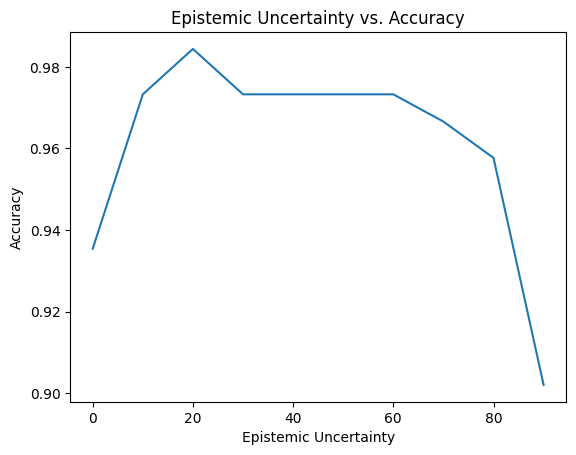

<Figure size 640x480 with 0 Axes>

In [14]:
# Plot epistemic uncertainty vs. classification accuracy
plt.xlabel("Epistemic Uncertainty")
plt.ylabel("Accuracy")
_ = mdl.lab3.plot_accuracy_vs_risk(epistemic_images, sorted_epistemic, sorted_epistemic_preds, "Epistemic Uncertainty vs. Accuracy")

## Capsa's `MVEWrapper`

With our base classifier, Capsa allows us to automatically convert it's last layer to it's mean-variance estimation (MVE) equivalent. Capsa's [`MVEWrapper`](https://themisai.io/capsa/api_documentation/MVEWrapper.html) implements this wrapping process. 

Specifically, `capsa.MVEWrapper` behaves in two different ways depending on whether model output is categorical or continuous.
- **Categorical**: Two additional dense layers are created. One is for mean, the other is for variance estimation of each category. Then, a point is sampled for each category using reparamaterization trick. During inference, we simply output these variance values, which gives us an estimate of variance in the dataset.
- **Continuous**: A separate and singular mean and variance variables are added at the end of the model. During training, we optimize the negative log likelihood between the ground truth continuous value and the normal distribution paramaterized by the mean and variance variables. 

The samples with the highest variance values have the highest aleatoric uncertainty; the samples with the lowest variance values have the lowest aleatoric uncertainty.

`capsa.MVEWrapper` takes in a number of arguments including:
1. `base_model`: the model to be transformed into the risk-aware variant.
2. `is_classification`: Whether the model is categorical or continuous. True==Categorical and False==Continuous


In [15]:
### Estimating aleatoric uncertainty with the MVE Wrapper ###

mve_model = make_standard_classifier(n_outputs=2)
# Wrap the CNN classifier for latent encoding with an MVE wrapper
mve_model = capsa.MVEWrapper(mve_model, is_classification=True)


# Build the model for classification, defining the loss function, optimizer, and metrics
mve_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), # for classification
    metrics=[tf.keras.metrics.CategoricalAccuracy()], # for classification
    run_eagerly=True
)


train_x,train_y = train_loader.images,tf.one_hot(train_loader.labels[:,0],depth=2)

# Train the wrapped model for 6 epochs by fitting to the training data
history = mve_model.fit(
        train_x,train_y,
        epochs=6,
        batch_size=batch_size,
  )

Epoch 1/6
859/859 [==============================] - 20s 21ms/step - mve_compiled_loss: 0.3018 - mve_compiled_categorical_accuracy: 0.8809 - mve_wrapper_loss: 0.5429
Epoch 2/6
859/859 [==============================] - 17s 20ms/step - mve_compiled_loss: 0.2409 - mve_compiled_categorical_accuracy: 0.9092 - mve_wrapper_loss: 0.4880
Epoch 3/6
859/859 [==============================] - 18s 20ms/step - mve_compiled_loss: 0.2362 - mve_compiled_categorical_accuracy: 0.9090 - mve_wrapper_loss: 0.4719
Epoch 4/6
859/859 [==============================] - 17s 20ms/step - mve_compiled_loss: 0.2256 - mve_compiled_categorical_accuracy: 0.9125 - mve_wrapper_loss: 0.4572
Epoch 5/6
859/859 [==============================] - 17s 20ms/step - mve_compiled_loss: 0.2180 - mve_compiled_categorical_accuracy: 0.9135 - mve_wrapper_loss: 0.4422
Epoch 6/6
859/859 [==============================] - 17s 20ms/step - mve_compiled_loss: 0.2056 - mve_compiled_categorical_accuracy: 0.9181 - mve_wrapper_loss: 0.4156


## Analyzing Aleatoric Uncertainty with Capsa

Now that we've trained our MVEWrapped model, let's look at our dataset's aleatoric uncertainty values. For the purpose of this analysis, we will gather the face samples separately from non-face samples. Afterwards, we can pass these two separate arrays to the mve wrapped model to get both the predictions as well as the aleatoric uncertainty values. 

In [16]:
# Evaluation
# Get all faces and nonfaces from both the test and the train datasets
face_images = np.vstack((test_loader.get_all_faces(), train_loader.get_all_faces()))
nonface_images = np.vstack(((test_loader.images[test_loader.neg_train_inds] / 255.0).astype(np.float32), \
                  (train_loader.images[train_loader.neg_train_inds] / 255.0).astype(np.float32)))

#get the predictions and variance on the Capsa-wrapped classifier
mve_face_predictions = mve_model(face_images)
mve_nonface_predictions = mve_model(nonface_images)

nonface_aleatorics = np.mean(mve_nonface_predictions.aleatoric,axis=-1)

Let's look at non-face samples. We will sort them according to their aleatoric uncertainty values. Afterwards, we will visualize 20 images from the LEAST and MOST aleatoric uncertainty samples. 

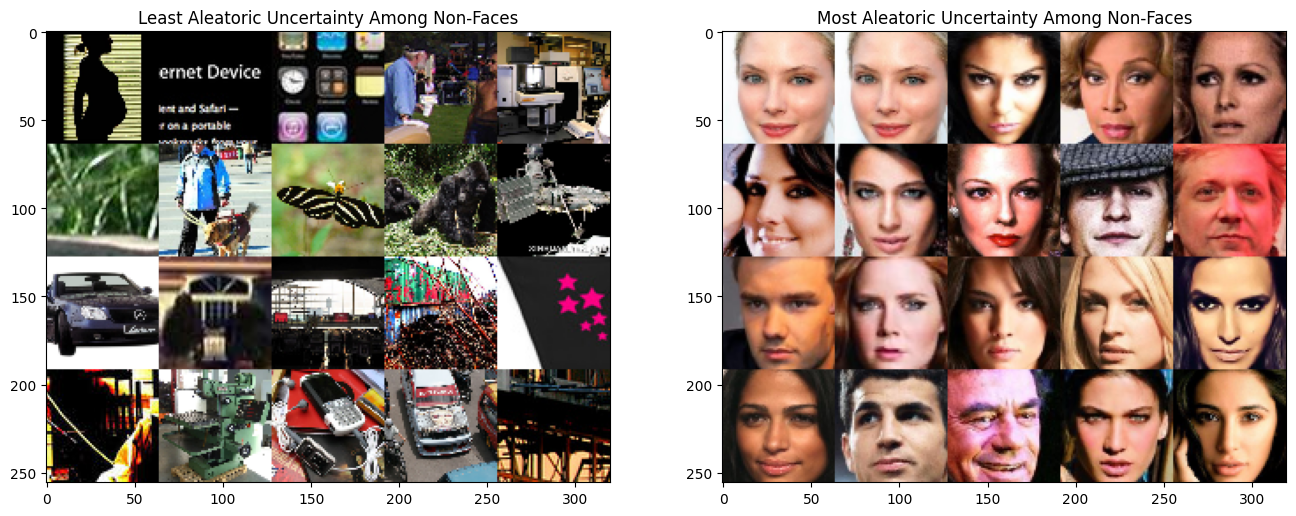

In [24]:
# Sort according to aleatoric uncertainty estimates
nonface_aleatoric_indices = np.argsort(nonface_aleatorics, axis=None) # sort the uncertainty values
aleatoric_nonface_images = nonface_images[nonface_aleatoric_indices] # sort images from lowest to highest uncertainty

# Visualize the 20 images with the LEAST and MOST aleatoric uncertainty
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(aleatoric_nonface_images[:20], (4, 5)))
ax[0].set_title("Least Aleatoric Uncertainty Among Non-Faces");

ax[1].imshow(mdl.util.create_grid_of_images(aleatoric_nonface_images[-20:], (4, 5)))
ax[1].set_title("Most Aleatoric Uncertainty Among Non-Faces");

We can clearly see that the samples with the highest aleatoric uncertainty are mostly faces. But this is a non-face dataset. Aleatoric uncertainty automatically helped us see the incorrectly labeled samples. We can use this information to improve the dataset.

## Other Wrappers

There are many other wrappers offered by capsa we haven't yet touched on this tutorial. Please check out [capsa documentation](http://themisai.io/capsa) for more information about other wrappers.